In [1]:
import config
import os, numpy as np, pandas, sklearn
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
context = data.init()

Setting up params

max min f 25.0 0.1
 >> Context(max_t=10.0, dt=0.02, n_instances=500, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)


In [5]:
# fn = (config.dataset_dir + '4-floor-120bpm.mid')
# mid = io.import_midifile(fn)

## Setup a generator

1. What is the least amount of 'hidden' nodes needed to learn a straight rythm (e.g. 8th notes with different frequencies)
2. Can we create a model of a generic function sin(2 pi f t + phase)
    - using x: t -> y: sin(2p t)
    - using x: [f, t, phase] -> y: sin(2p f t + phase)
    - using x: sin([t1, t2, t3) -> y: [f, t, phase]
        - such a model should be able to learn complex patterns, such as sin(f1+p1) + sin(f2+p2) + sin(f3+p3)

In [169]:
n = 100
min_f = 3
max_f = 20
x_train = g.gen_data(context, n, max_f=max_f, min_f=min_f)
# x_train = np.zeros([10,100,127])
y_train = x_train

render sin, f =  12.470345010534913
WARNING type not == 0
render sin, f =  4.169403415148148
WARNING type not == 0
render sin, f =  9.758080643355019
WARNING type not == 0
render sin, f =  14.862618412517357
WARNING type not == 0
render sin, f =  4.689992319095513
WARNING type not == 0
render sin, f =  13.876506207224613
WARNING type not == 0
render sin, f =  14.404645941445109
WARNING type not == 0
render sin, f =  9.283938930319595
WARNING type not == 0
render sin, f =  19.1280502199457
WARNING type not == 0
render sin, f =  12.345282459689638
WARNING type not == 0
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  9.994791666666638
 |>  500
render sin, f =  7.906222922302494
WARNING type not == 0
render sin, f =  9.013815544930576
WARNING type not == 0
render sin, f =  13.070753125038252
WARNING type not == 0
render sin, f =  6.472368665429241
WARNING type not == 0
render sin, f =  12.214455265786937
WARNING type not == 0
render sin, f =  17.46810281701691
WARNING type not == 0


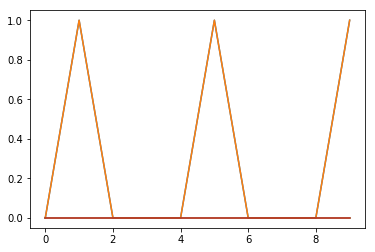

In [170]:
plt.plot(x_train[0,:10,0:2])
plt.plot(x_train[1,:10,0:2])

In [171]:
# [sum(x) for x in x_train]
x_train.shape

(100, 500, 2)

In [224]:
y_train = x_train
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:]
# output_length = y_train.shape[1]
# output_length = (y_train[0]).shape[0] # = length of an individual label
hidden_layer_length = 10
x_train.shape

(100, 500, 2)

In [268]:
# functional syntax: lambda x: lambda y: z
def encoder(input_shape, output_length, dropout=0.10):
    input_layer = Input(shape=input_shape)
    x = input_layer
    x = Flatten()(x)
#     x = Dense(output_length * 2, activation='relu')(x)    
#     x = Dropout(dropout)(x)
#     x = Dense(output_length, activation='relu')(x)
    x = Dense(output_length, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(output_length, activation='relu')(x)
#     x = Dense(output_length, activation='sigmoid')(x)
#     x = Dropout(dropout)(x)
#     x = Dense(output_length, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x)
    #     model.add(Dropout(dropout))    
    model = Model(inputs=input_layer, outputs=x)
    return model


def decoder(input_length, output_shape, dropout=0.10):
    input_layer = Input(shape=(input_length,))
    x = input_layer
    shape = output_shape
    # shape = (10,100) # increase n dimensions
    
    x = Dense(np.prod(shape), activation='relu')(x)
#     x = Dense(np.prod(shape), activation='relu')(x)
#     x = Dropout(dropout)(x)
    x = Dropout(dropout)(x)
    x = Dense(np.prod(shape), activation='sigmoid')(x)
#     x = Dense(np.prod(shape), activation='sigmoid')(x) # 4*4*8 = 128
    x = Reshape(shape)(x)
#     x = UpSampling1D(10)(x)
    # make sure the conv layer increases the amount of dimensions
#     dims = keras.backend.int_shape(x)[1:]
#     n_steps = output_shape[0]
#     n_output_timesteps = output_shape[1]
#     filters = n_output_timesteps
#     conv_amt = 2
#     print('__+++==', n_output_timesteps)
#     x = Conv1D(filters, kernel_size=4, strides=2, activation='relu')(x) # 50,100

    dims = keras.backend.int_shape(x)[1:]
#     x = UpSampling1D(dims[0] * 2)(x)
#     x = Dense(output_shape[1], activation='relu')(x)
    #     x = LocallyConnected1D(output_shape[1], kernel_size=1, activation='relu')(x)
    # x = Dense(output_length, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=x)
    #     model.add(Dropout(dropout))
    return model


def autoencoder(input_shape, output_shape, hidden_layer_length=10, dropout=0.10, verbose=False):
    input_ = Input(shape=input_shape)
    encode = encoder(input_shape, hidden_layer_length, dropout)
    if verbose:
        encode.summary()
    decode = decoder(hidden_layer_length, output_shape, dropout)
    if verbose:
        decode.summary()
    model = Model(input_, decode(encode(input_)))
    return encode, decode, model

dropout = 0.1
encoder, decoder, auto = autoencoder(input_shape, output_shape, hidden_layer_length, dropout, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        (None, 500, 2)            0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1000)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 10)                10010     
_________________________________________________________________
dropout_11 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 10)                110       
Total params: 10,120
Trainable params: 10,120
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_

In [269]:
metrics = ['accuracy','mse','mae']
loss = 'binary_crossentropy'# binary_crossentropy categorical_crossentropy
optimizer = 'adam'
auto.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [270]:
batch_size = 15
# n epochs = n iterations over all the training data
epochs = 150

In [271]:
m = 30
# xx = np.stack([x_train[0] for _ in range(m)])
# yy = xx
# history = auto.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
history = auto.fit(x_train[:m], y_train[:m], epochs=epochs, batch_size=batch_size,
          validation_split=1/6, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])

Train on 25 samples, validate on 5 samples
Epoch 1/150
25/25 [==============================] - 0s 13ms/step - loss: 0.6921 - acc: 0.5452 - mean_squared_error: 0.2495 - mean_absolute_error: 0.4994 - val_loss: 0.6861 - val_acc: 0.6510 - val_mean_squared_error: 0.2465 - val_mean_absolute_error: 0.4963
Epoch 2/150
25/25 [==============================] - 0s 3ms/step - loss: 0.6832 - acc: 0.6914 - mean_squared_error: 0.2450 - mean_absolute_error: 0.4948 - val_loss: 0.6712 - val_acc: 0.7368 - val_mean_squared_error: 0.2391 - val_mean_absolute_error: 0.4879
Epoch 3/150
25/25 [==============================] - 0s 4ms/step - loss: 0.6653 - acc: 0.7538 - mean_squared_error: 0.2361 - mean_absolute_error: 0.4849 - val_loss: 0.6469 - val_acc: 0.7564 - val_mean_squared_error: 0.2271 - val_mean_absolute_error: 0.4719
Epoch 4/150
25/25 [==============================] - 0s 3ms/step - loss: 0.6333 - acc: 0.7712 - mean_squared_error: 0.2204 - mean_absolute_error: 0.4647 - val_loss: 0.6190 - val_acc: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.4363 - acc: 0.7908 - mean_squared_error: 0.1427 - mean_absolute_error: 0.2931 - val_loss: 0.6119 - val_acc: 0.7582 - val_mean_squared_error: 0.2017 - val_mean_absolute_error: 0.3889
Epoch 33/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4425 - acc: 0.7902 - mean_squared_error: 0.1451 - mean_absolute_error: 0.2986 - val_loss: 0.6126 - val_acc: 0.7580 - val_mean_squared_error: 0.2016 - val_mean_absolute_error: 0.3876
Epoch 34/150
25/25 [==============================] - 0s 3ms/step - loss: 0.4372 - acc: 0.7901 - mean_squared_error: 0.1431 - mean_absolute_error: 0.2981 - val_loss: 0.6145 - val_acc: 0.7580 - val_mean_squared_error: 0.2016 - val_mean_absolute_error: 0.3852
Epoch 35/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4242 - acc: 0.7960 - mean_squared_error: 0.1387 - mean_absolute_error: 0.2811 - val_loss: 0.6163 - val_acc: 0.7576 - val_mean_squared_error: 0.2015 - val_mean_abso

Epoch 64/150
25/25 [==============================] - 0s 3ms/step - loss: 0.3502 - acc: 0.8254 - mean_squared_error: 0.1155 - mean_absolute_error: 0.2366 - val_loss: 0.6603 - val_acc: 0.7374 - val_mean_squared_error: 0.2060 - val_mean_absolute_error: 0.3748
Epoch 65/150
25/25 [==============================] - 0s 2ms/step - loss: 0.3246 - acc: 0.8360 - mean_squared_error: 0.1065 - mean_absolute_error: 0.2235 - val_loss: 0.6568 - val_acc: 0.7368 - val_mean_squared_error: 0.2054 - val_mean_absolute_error: 0.3741
Epoch 66/150
25/25 [==============================] - 0s 3ms/step - loss: 0.3438 - acc: 0.8296 - mean_squared_error: 0.1130 - mean_absolute_error: 0.2353 - val_loss: 0.6539 - val_acc: 0.7360 - val_mean_squared_error: 0.2051 - val_mean_absolute_error: 0.3739
Epoch 67/150
25/25 [==============================] - 0s 3ms/step - loss: 0.3205 - acc: 0.8388 - mean_squared_error: 0.1055 - mean_absolute_error: 0.2191 - val_loss: 0.6576 - val_acc: 0.7366 - val_mean_squared_error: 0.2055 - 

Epoch 96/150
25/25 [==============================] - 0s 3ms/step - loss: 0.2348 - acc: 0.8896 - mean_squared_error: 0.0748 - mean_absolute_error: 0.1680 - val_loss: 0.7321 - val_acc: 0.7224 - val_mean_squared_error: 0.2116 - val_mean_absolute_error: 0.3571
Epoch 97/150
25/25 [==============================] - 0s 3ms/step - loss: 0.2518 - acc: 0.8778 - mean_squared_error: 0.0812 - mean_absolute_error: 0.1742 - val_loss: 0.7419 - val_acc: 0.7244 - val_mean_squared_error: 0.2123 - val_mean_absolute_error: 0.3553
Epoch 98/150
25/25 [==============================] - 0s 2ms/step - loss: 0.2267 - acc: 0.8884 - mean_squared_error: 0.0725 - mean_absolute_error: 0.1614 - val_loss: 0.7467 - val_acc: 0.7272 - val_mean_squared_error: 0.2125 - val_mean_absolute_error: 0.3538
Epoch 99/150
25/25 [==============================] - 0s 3ms/step - loss: 0.2372 - acc: 0.8817 - mean_squared_error: 0.0761 - mean_absolute_error: 0.1635 - val_loss: 0.7436 - val_acc: 0.7232 - val_mean_squared_error: 0.2122 - 

25/25 [==============================] - 0s 3ms/step - loss: 0.1850 - acc: 0.9088 - mean_squared_error: 0.0585 - mean_absolute_error: 0.1275 - val_loss: 0.7798 - val_acc: 0.7176 - val_mean_squared_error: 0.2175 - val_mean_absolute_error: 0.3512
Epoch 128/150
25/25 [==============================] - 0s 3ms/step - loss: 0.1660 - acc: 0.9203 - mean_squared_error: 0.0519 - mean_absolute_error: 0.1183 - val_loss: 0.7794 - val_acc: 0.7158 - val_mean_squared_error: 0.2171 - val_mean_absolute_error: 0.3502
Epoch 129/150
25/25 [==============================] - 0s 2ms/step - loss: 0.1742 - acc: 0.9245 - mean_squared_error: 0.0533 - mean_absolute_error: 0.1182 - val_loss: 0.7847 - val_acc: 0.7138 - val_mean_squared_error: 0.2171 - val_mean_absolute_error: 0.3488
Epoch 130/150
25/25 [==============================] - 0s 3ms/step - loss: 0.2415 - acc: 0.8913 - mean_squared_error: 0.0762 - mean_absolute_error: 0.1548 - val_loss: 0.7921 - val_acc: 0.7096 - val_mean_squared_error: 0.2182 - val_mean_a

(0, 0.8662481091916561)

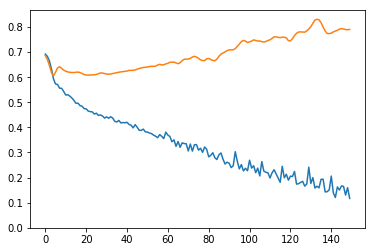

In [272]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(ymin=0)

(0, 1)

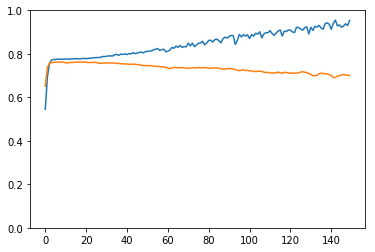

In [273]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylim(ymin=0, ymax=1)

In [274]:
mid1 = g.render_midi(context, f=2)
mid2 = g.render_midi(context, f=3)
x_test = np.stack([midi.encode(context, m) for m in [mid1,mid2]])

render sin, f =  2
render sin, f =  3
WARNING type not == 0
WARNING type not == 0


In [275]:
# maxx = np.maximum(latent[0],latent[1])
# maxx.shape

In [276]:
# arrays = decoder.predict(np.stack([latent[1]]))
results = auto.predict(x_train[:10])
results.shape

(10, 500, 2)

(0, 1)

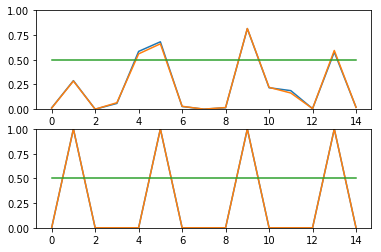

In [277]:
n1 = 15
i = 0
plt.subplot(211)
plt.plot(np.arange(n1), results[i, :n1, 0:])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)

plt.subplot(212)
plt.plot(np.arange(n1), x_train[i, :n1, 0:])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)

(0, 1)

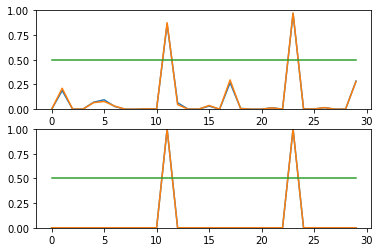

In [278]:
n1 = 30
i = 1
plt.subplot(211)
plt.plot(np.arange(n1), results[i, :n1, 0:])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)
plt.subplot(212)

plt.plot(np.arange(n1), x_train[i, :n1, 0:])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)

In [279]:
mid_true = midi.decode_track(context, x_train[0])
mid_pred = midi.decode_track(context, arrays[0])

 [INFO] : 
 |  len, max_t
 |  10.01562499999999
 |  10.0
 [INFO] : 
 |  len, max_t
 |  9.990624999999987
 |  10.0


In [280]:
dn = config.export_dir
io.export_midifile(mid_true, dn + 'mid_true.mid')
io.export_midifile(mid_pred, dn + 'mid_pred.mid')

In [281]:
mid

<midi file None type 1, 1 tracks, 480 messages>

In [282]:
mid

<midi file None type 1, 1 tracks, 480 messages>